![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/1.3.Trasformer_based_Text_Recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

**Please choose GPU runtime**

In [2]:
# NBVAL_SKIP
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# NBVAL_SKIP
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install transformers==4.16.2
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
SPARK_OCR_SECRET = ""

In [1]:
# NBVAL_SKIP
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark_ocr_jar_path = "../../../target/scala-2.12/"
spark = start(secret=SPARK_OCR_SECRET, jar_path=spark_ocr_jar_path)

18:46:11, INFO 65004
18:46:12, INFO Adding jar from /Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkmonitor/listener_2.12.jar 


Spark version: 3.2.1
Spark NLP version: 5.2.0
Spark NLP for Healthcare version: 5.2.0
Spark OCR version: 5.1.0



18:46:19, INFO Client Connected ('127.0.0.1', 65013)


## Read image


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


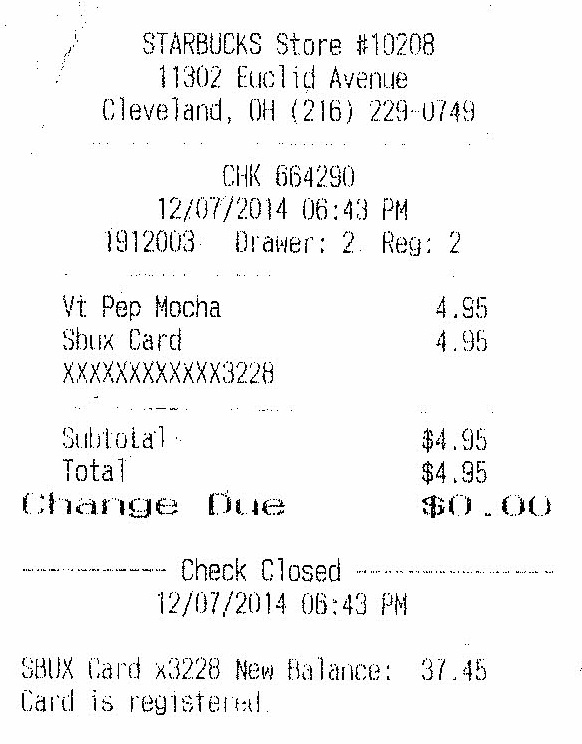

In [4]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path)
image_df = BinaryToImage().transform(image_example_df).cache()

display_images(image_df)

In [5]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


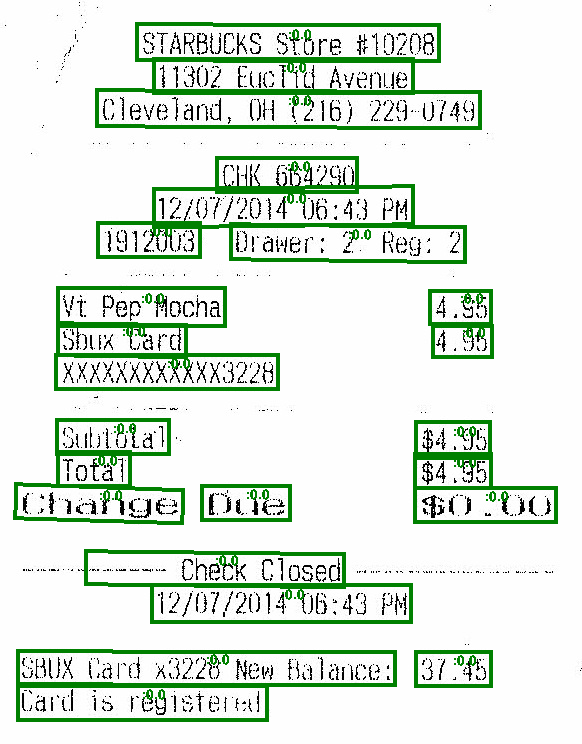

In [6]:
result = pipeline.transform(image_example_df)
display_images(result, "image_with_regions")

## Disable refiner and tune thresholds for detect each word separately


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


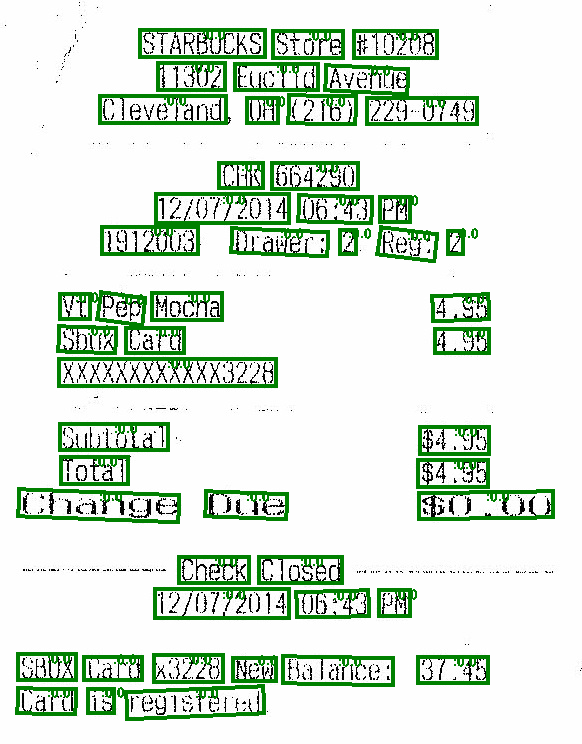

In [7]:
pipeline.stages[1].setWithRefiner(False)
pipeline.stages[1].setSizeThreshold(15)
pipeline.stages[1].setLinkThreshold(0.3)
pipeline.stages[1].setScoreThreshold(0.7)
pipeline.stages[1].setTextThreshold(0.4)
pipeline.stages[1].setMergeIntersects(True)

result = pipeline.transform(image_example_df)
display_images(result, "image_with_regions")

In [8]:
ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)

print(("").join([x.text for x in ocr.transform(result).select("text").collect()]))

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAWER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [9]:
ocr_formatted = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("text_formatted") \
    .setOutputFormat(OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)

print(("").join([x.text_formatted for x in ocr_formatted.transform(result).select("text_formatted").collect()]))

       STARBUCKS STORE #10208
      11302 EUCLID AVENUE
     CLEVELAND OH (216) 229-0749

        CHK 664290
       12/07/2014 06:43 PM
     1912003 DRAWER: 2 REG: 2

  VT PEP MOCHA  4.95
   SBUX CARD    4.95
     XXXXXXXXXXXX3228

    SUBTOTAL    $4.95
   TOTAL        $4.95
   CHANGE DUE    $0.00

       CHECK CLOSED
       12/07/2014 06:43 PM

 SBUX CARD X3228 NEW BALANCE: 37.45
 CARD IS REGISTERED


### Define pipeline for recognize text and get results in HOCR format

In [11]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setSizeThreshold(15) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("hocr") \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setGroupImages(False) 

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(14) \
    .setRectColor(Color.red)

hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    tokenizer,
    draw_annotations
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB



    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


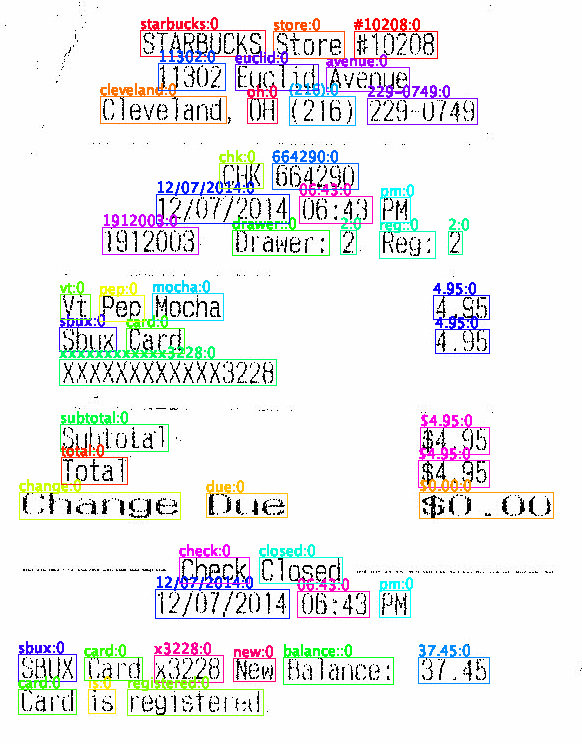

In [12]:
hocr_result = hocr_pipeline.transform(image_example_df).cache()
display_images(hocr_result, "image_with_annotations", width=1000)

In [13]:
print(hocr_result.select("hocr").collect()[0].hocr)

<div title="bbox 0 0 582 744" id="page_0" class="ocr_page"><div title="bbox 0 0 582 744" id="block_1" class="ocr_carea"><span title="bbox 140 30 265 56" id="word_1" class="ocrx_word">STARBUCKS</span><span title="bbox 273 31 344 58" id="word_2" class="ocrx_word">STORE</span><span title="bbox 354 31 437 58" id="word_3" class="ocrx_word">#10208</span><span title="bbox 158 63 225 90" id="word_4" class="ocrx_word">11302</span><span title="bbox 235 64 318 90" id="word_5" class="ocrx_word">EUCLID</span><span title="bbox 326 67 409 91" id="word_6" class="ocrx_word">AVENUE</span><span title="bbox 100 96 226 123" id="word_7" class="ocrx_word">CLEVELAND</span><span title="bbox 247 98 277 123" id="word_8" class="ocrx_word">OH</span><span title="bbox 289 96 355 125" id="word_9" class="ocrx_word">(216)</span><span title="bbox 367 98 477 124" id="word_10" class="ocrx_word">229-0749</span><span title="bbox 219 163 263 188" id="word_11" class="ocrx_word">CHK</span><span title="bbox 272 163 358 189" id=